# Get data

In [1]:
import os
import shutil
import zipfile

if not os.path.exists('./Data'):
    os.mkdir('Data')

In [4]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O ./Data/cats_and_dogs_filtered.zip

--2021-05-17 13:29:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.195.240, 142.250.196.48, 142.250.76.48, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.195.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./Data/cats_and_dogs_filtered.zip’

./Data/cats_and_dog 100%[===================>]  65.43M  7.02MB/s    in 19s     

2021-05-17 13:29:56 (3.49 MB/s) - ‘./Data/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [5]:
if not os.path.exists('./Data/cats_and_dogs_filtered/'):
    local_zip = './Data/cats_and_dogs_filtered.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('./Data/')
    zip_ref.close()
    os.remove('./Data/cats_and_dogs_filtered.zip')

# Data generator

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    rotation_range=40,
    fill_mode='nearest'

)
train_datagen = train_gen.flow_from_directory(
    './Data/cats_and_dogs_filtered/train',
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

val_gen = ImageDataGenerator(rescale=1./255)
val_datagen = train_gen.flow_from_directory(
    './Data/cats_and_dogs_filtered/validation',
    target_size=(150, 150),
    batch_size=10,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Model defination

In [3]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [4]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(lr=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Define callback

In [ ]:
class customCallBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if logs.get("accuracy") > 0.90:
            print("Stopping training because accuracy is more than 90%")
            self.model.stop_training = True

callback = customCallBack()

# Train

In [5]:
history = model.fit_generator(
    train_datagen,
    epochs=15,
    verbose=1,
    validation_data=val_datagen
)

/Users/neeraj/virtualenv/python3/coursera_tensorflow_venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/15
100/100 [==============================] - 30s 284ms/step - loss: 0.8375 - accuracy: 0.5164 - val_loss: 0.6628 - val_accuracy: 0.6110
Epoch 2/15
100/100 [==============================] - 33s 330ms/step - loss: 0.6356 - accuracy: 0.6588 - val_loss: 0.6052 - val_accuracy: 0.6770
Epoch 3/15
100/100 [==============================] - 32s 321ms/step - loss: 0.5625 - accuracy: 0.7128 - val_loss: 0.5651 - val_accuracy: 0.7120
Epoch 4/15
100/100 [==============================] - 28s 281ms/step - loss: 0.4691 - accuracy: 0.7922 - val_loss: 0.5264 - val_accuracy: 0.7350
Epoch 5/15
100/100 [==============================] - 35s 354ms/step - loss: 0.3756 -

# Predict

In [16]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def get_image_to_test_and_train(path):
    image = load_img(path, target_size=(150, 150))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)

    images = np.vstack([image])
    return images 

In [28]:
image_path = "./Data/test_images/dog-cat-lowres-web.jpg"
image = get_image_to_test_and_train(image_path)
calsses = model.predict(image)[0][0]
if calsses == 0:
    print("Cat")
else:
    print("Dog")

Cat


# Plot loss and accuracy

In [31]:
print("Data we have : ", history.history.keys())

Data we have :  dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


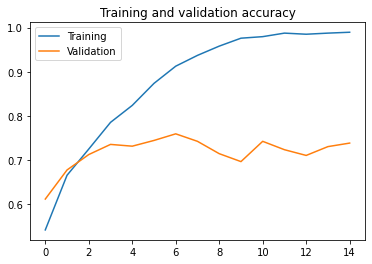

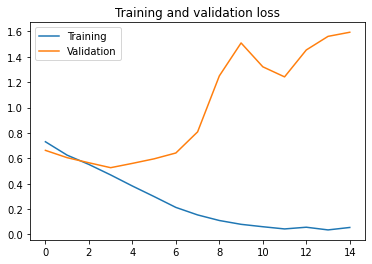

In [44]:
import  matplotlib.pyplot as plt

no_of_epochs = len(history.history["accuracy"])
epochs = range(no_of_epochs)
plt.plot(epochs, history.history["accuracy"], label="Training")
plt.plot(epochs, history.history["val_accuracy"], label="Validation")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()
plt.plot(epochs, history.history["loss"], label="Training")
plt.plot(epochs, history.history["val_loss"], label="Validation")
plt.title("Training and validation loss")
plt.legend()

# Visualization

This is my simple method where I just show the 1st feature map in each layer

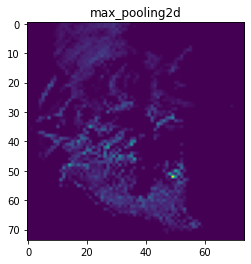

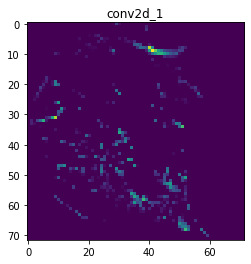

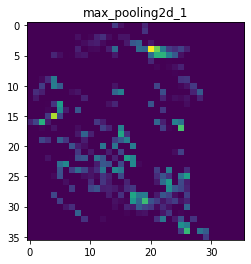

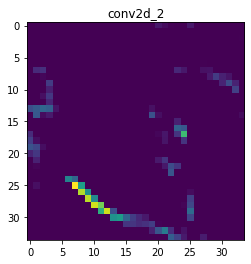

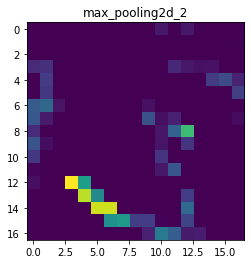

In [81]:
feature_maps = [layer.output for layer in model.layers[1:]]
feature_map_names = [layer.name for layer in model.layers[1:]]

viz_model = tf.keras.Model(inputs=model.input, outputs=feature_maps)
image = get_image_to_test_and_train("./Data/test_images/dog-cat-lowres-web.jpg")
viz_preds = viz_model.predict(image)
for name, layer in zip(feature_map_names, viz_preds):
    layer_shape = layer.shape
    if len(layer_shape) != 4:
        continue
    plt.figure()
    plt.title(name)
    layer = layer.reshape((layer_shape[1], layer_shape[2], layer_shape[3]))
    layer = layer.swapaxes(2, 0)
    for sub_layer in layer:
        plt.imshow(sub_layer)
        break


This is their complicated yet neat method to fit all feature maps

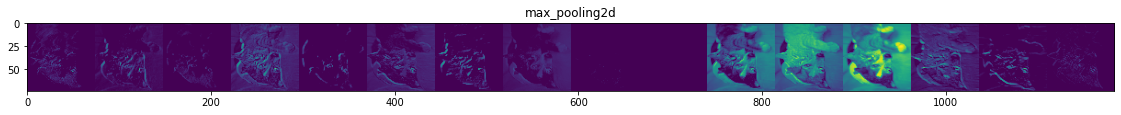

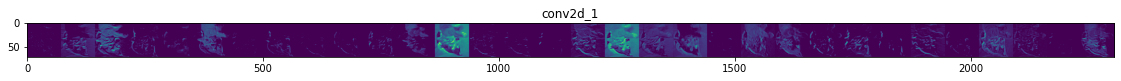

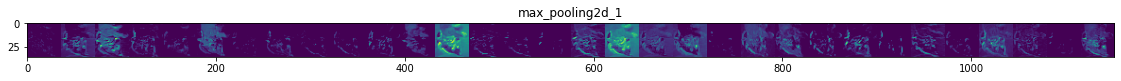

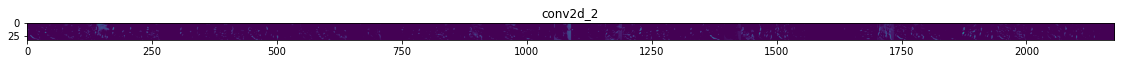

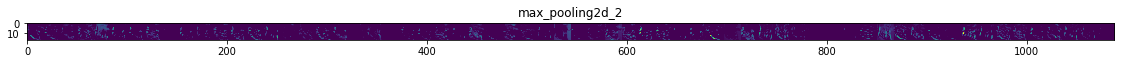

In [85]:
feature_maps = [layer.output for layer in model.layers[1:]]
feature_map_names = [layer.name for layer in model.layers[1:]]

viz_model = tf.keras.Model(inputs=model.input, outputs=feature_maps)
image = get_image_to_test_and_train("./Data/test_images/dog-cat-lowres-web.jpg")
viz_preds = viz_model.predict(image)
for name, layer in zip(feature_map_names, viz_preds):
    layer_shape = layer.shape
    if len(layer_shape) != 4:
        continue
    layer = layer.reshape((layer_shape[1], layer_shape[2], layer_shape[3]))
    layer = layer.swapaxes(2, 0)
    empty_image = np.zeros((layer_shape[1], layer_shape[2]*layer_shape[3]))
    for index, sub_layer in enumerate(layer):
        empty_image[:, index*layer_shape[2]:(index+1)*layer_shape[2]] = sub_layer
    scale = 20. / layer_shape[3]
    plt.figure(figsize=(scale*layer_shape[3], scale))
    plt.title(name)
    plt.imshow(empty_image)